In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle

from adaptive_time.utils import set_directory_in_project

from importlib import reload
from joblib import Parallel, delayed
from tqdm.notebook import tqdm

from pprint import pprint


In [2]:
from adaptive_time import plot_utils
from adaptive_time import utils
from adaptive_time import run_lib
from adaptive_time import value_est
from adaptive_time.value_est import approx_integrators

approx_integrators = reload(approx_integrators)
run_lib = reload(run_lib)
value_est = reload(value_est)
plot_utils = reload(plot_utils)
utils = reload(utils)

In [3]:
set_directory_in_project()
data_dir = "./data"
env_names = [env_name for env_name in os.listdir(data_dir) if not env_name.startswith(".DS_Store")]
print(env_names)

Changed working directory to /Users/chanb/research/ualberta/adaptive_time
['inverted_double_pendulum-v2', 'swimmer-v3', 'hopper-v3', 'ant-v3', 'cheetah-v3', 'pusher-v2']


In [4]:
samplers_tried = dict(
    q100=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=100),
    q10=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=10),
    q1=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=1),
    q0=approx_integrators.AdaptiveQuadratureIntegrator(tolerance=0),
    u1=approx_integrators.UniformlySpacedIntegrator(1),
    u10=approx_integrators.UniformlySpacedIntegrator(50),
    u500=approx_integrators.UniformlySpacedIntegrator(500),
)

In [5]:
def compute_approx_integrals(
    reward_file: str,
    samplers_tried: dict,
):
    print(reward_file)
    reward_sequences = np.load(reward_file).T
    idxes = np.where(reward_sequences[:, 0][:, None] - reward_sequences[:, 0][None, :] == 0)
    
    if len(idxes[0]) == len(idxes[1]):
        assert np.sum(idxes[0] - idxes[1]) == 0
    else:
        assert 0

    approx_integrals = {}
    num_pivots = {}
    for sampler_name, sampler in samplers_tried.items():
        approx_integrals[sampler_name] = []
        num_pivots[sampler_name] = []
        for idx, reward_seq in enumerate(reward_sequences):
            integral, all_pivots = sampler.integrate(reward_seq)
            approx_integrals[sampler_name].append(integral)
            num_pivots[sampler_name].append(len(all_pivots))
        approx_integrals[sampler_name] = np.array(approx_integrals[sampler_name])
        num_pivots[sampler_name] = np.array(num_pivots[sampler_name])

    return {
        "reward_file": np.array([reward_file]),
        "approx_integrals": approx_integrals,
        "num_pivots": num_pivots,
    }

In [6]:
all_results = {}

In [7]:
checkpoint = "./mujoco_val_est.pkl"
if not os.path.isfile(checkpoint):
    for env_name in tqdm(env_names):
        if env_name in all_results:
            continue
        print("env: {}".format(env_name))

        env_dir = os.path.join(data_dir, env_name)
        all_results.setdefault(env_name, {})
        run_files = [run_file for run_file in os.listdir(env_dir) if not run_file.startswith(".DS_Store")]
        all_results[env_name] = Parallel(
            n_jobs=len(run_files)
        )(
            delayed(compute_approx_integrals)(
                os.path.join(env_dir, run_file),
                samplers_tried,
            )
            for run_file in run_files
        )
    pickle.dump(all_results, open(checkpoint, "wb"))
else:
    all_results = pickle.load(open(checkpoint, "rb"))

  0%|          | 0/6 [00:00<?, ?it/s]

env: inverted_double_pendulum-v2


./data/inverted_double_pendulum-v2/Rewards_50000_1000_9.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_8.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_7.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_6.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_5.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_4.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_0.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_1.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_3.npy
./data/inverted_double_pendulum-v2/Rewards_50000_1000_2.npy
env: swimmer-v3
./data/swimmer-v3/Rewards_40000_1000_8.npy
./data/swimmer-v3/Rewards_40000_1000_9.npy
./data/swimmer-v3/Rewards_40000_1000_2.npy
./data/swimmer-v3/Rewards_40000_1000_3.npy
./data/swimmer-v3/Rewards_40000_1000_1.npy
./data/swimmer-v3/Rewards_40000_1000_0.npy
./data/swimmer-v3/Rewards_40000_1000_4.npy
./data/swimmer-v3/Rewards_40000_1000_5.npy
./data/swimmer-v3/Rewards_40000_1000_7.n

In [8]:
import jax

In [12]:
agg_results = {
    env_name: jax.tree_util.tree_map(
        lambda *args: np.concatenate(args),
        *all_results[env_name]
    ) for env_name in all_results
}

In [13]:
combined_checkpoint = "./combined_mujoco_val_est.pkl"
pickle.dump(agg_results, open(combined_checkpoint, "wb"))

In [14]:
agg_results["ant-v3"]["approx_integrals"]["q100"].shape

(10000,)

In [18]:
update_budget = 10_000_000
sample_block = 1_000_000

est_results = {}
num_seeds = 10

for env_name in agg_results:
    print(env_name)
    vals_per_state = np.concatenate(
        [np.sum(np.load(reward_file).T, axis=-1) for reward_file in agg_results[env_name]["reward_file"]]
    )
    print(vals_per_state.shape)

    approx_integrals = agg_results[env_name]["approx_integrals"]
    num_pivots = agg_results[env_name]["num_pivots"]

    weights = np.ones(len(vals_per_state)) / len(vals_per_state)
    true_value = np.sum(weights * vals_per_state)

    est_results[env_name] = {
        "weights": weights,
        "true_value": true_value,
        "runs": []
    }

    for seed in tqdm(range(num_seeds)):
        estimated_values_by_episode = {}
        number_of_pivots_by_episode = {}
        all_values_by_episode = {}

        rng = np.random.RandomState(seed)
        start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))

        for sampler_name, sampler in samplers_tried.items():
            # print("sampler_name:", sampler_name)
            # Update the value estimate with new samples until we run out of budget.
            used_updates = 0
            value_estimate = 0
            num_episodes = 0
            all_values_by_episode[sampler_name] = []

            estimated_values_by_episode[sampler_name] = []
            number_of_pivots_by_episode[sampler_name] = []

            # pbar = tqdm(total = update_budget)
            while used_updates < update_budget:
                num_episodes += 1
                if num_episodes % sample_block == 0:
                    start_states = rng.choice(len(vals_per_state), p=weights, size=(update_budget))
                start_state = start_states[(num_episodes - 1) % sample_block]
                val_sample = approx_integrals[sampler_name][start_state]
                all_values_by_episode[sampler_name].append(val_sample)
                
                value_estimate += (1.0/num_episodes) * (val_sample - value_estimate)
                used_updates += num_pivots[sampler_name][start_state]

                estimated_values_by_episode[sampler_name].append(value_estimate)
                number_of_pivots_by_episode[sampler_name].append(used_updates)
            #     pbar.update(num_pivots[sampler_name][start_state])
            # pbar.close()
        est_results[env_name]["runs"].append({
            "estimated_values_by_episode": estimated_values_by_episode,
            "number_of_pivots_by_episode": number_of_pivots_by_episode,
            "all_values_by_episode": all_values_by_episode,
        })


inverted_double_pendulum-v2
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

swimmer-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

hopper-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

ant-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

cheetah-v3
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

pusher-v2
(10000,)


  0%|          | 0/10 [00:00<?, ?it/s]

In [19]:
estimator_checkpoint = "./estimator_mujoco_val_est.pkl"
pickle.dump(est_results, open(estimator_checkpoint, "wb"))

In [ ]:
assert 0

In [20]:
# Verify final means.
for key, value in estimated_values_by_episode.items():
    mean_total = np.mean(all_values_by_episode[key])
    mean_updated = value[-1]
    print("sampler:", key, "mean_total:", mean_total, "mean_updated:", mean_updated)
    if abs(mean_total - mean_updated) > 0.01:
        assert False, f"Means don't match for {key}: {mean_total} vs {mean_updated}"
    


sampler: q100 mean_total: -7309.9592493803275 mean_updated: -7309.959249380297
sampler: q10 mean_total: -7324.16969828483 mean_updated: -7324.169698284823
sampler: q1 mean_total: -7318.7420619173845 mean_updated: -7318.742061917403
sampler: q0 mean_total: -7539.061173569941 mean_updated: -7539.061173569941
sampler: u1 mean_total: -7545.041565689812 mean_updated: -7545.041565689813
sampler: u10 mean_total: -7314.760069077069 mean_updated: -7314.760069077051
sampler: u500 mean_total: -7342.301359235983 mean_updated: -7342.301359235964


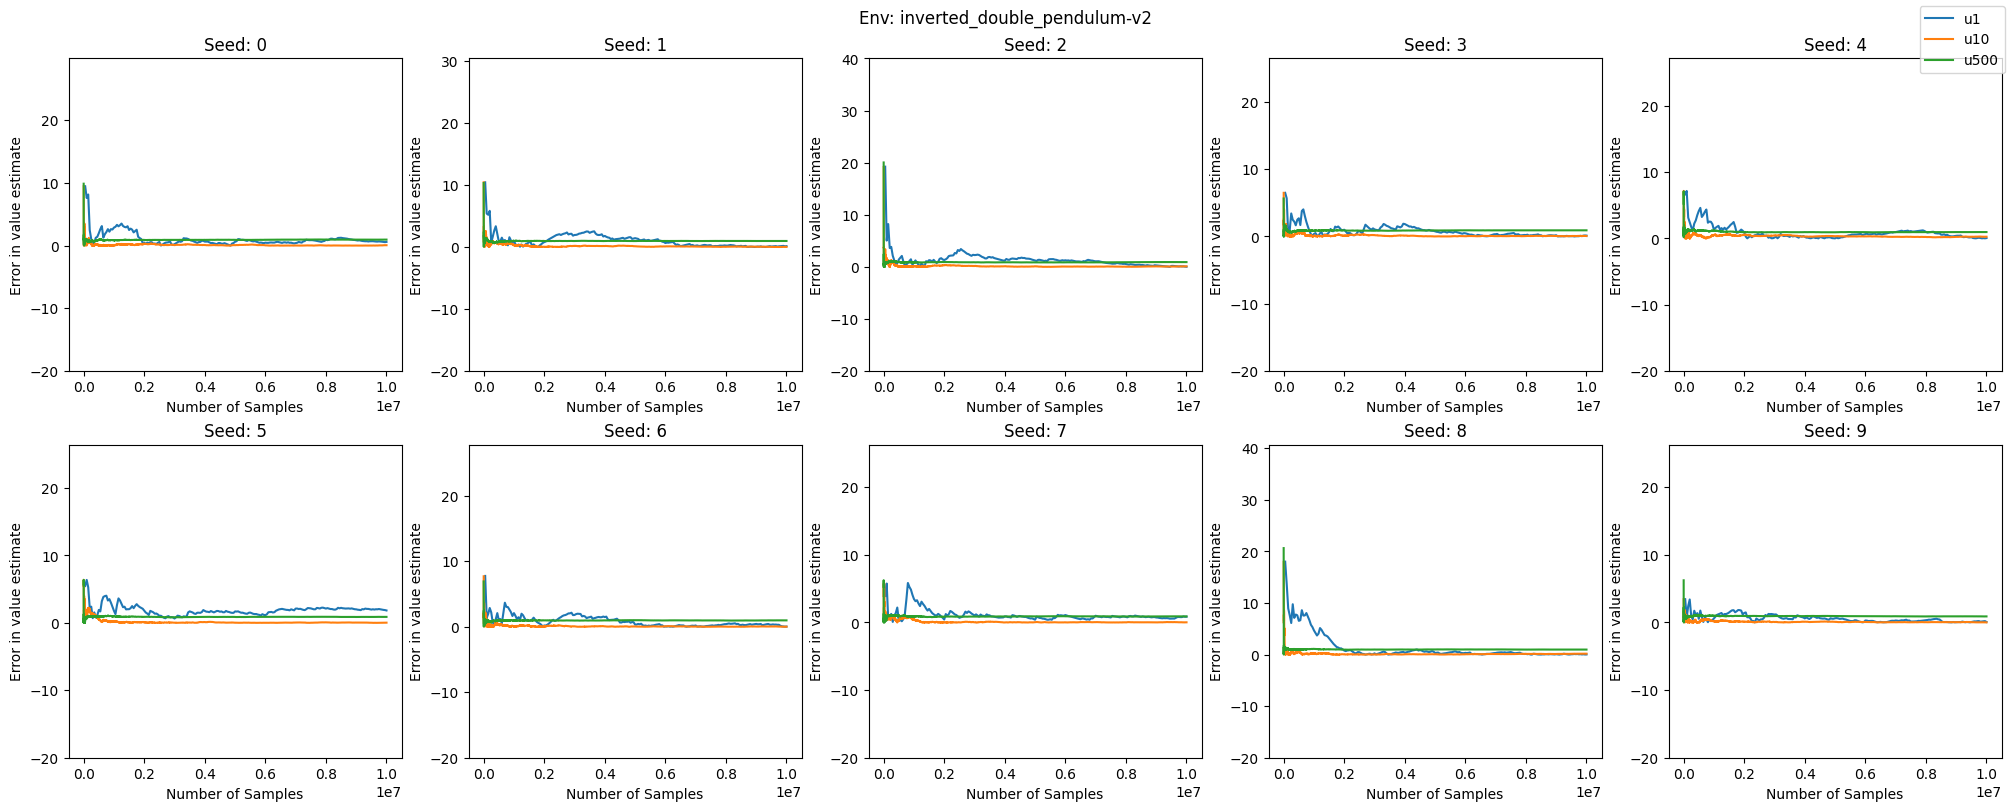

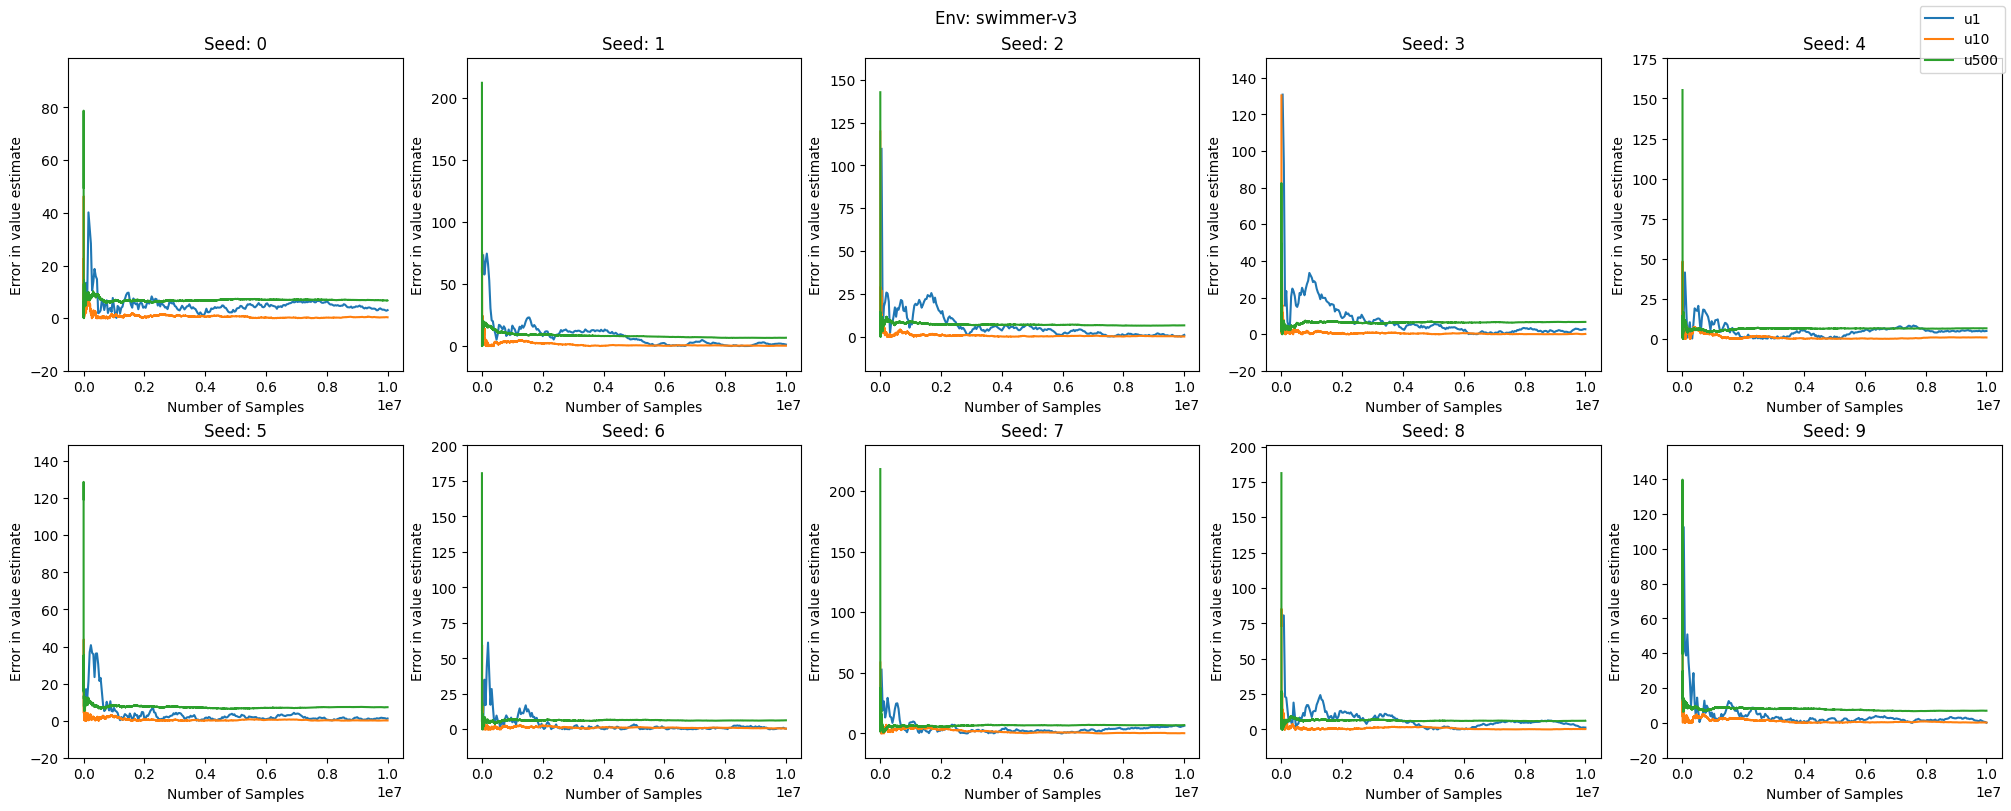

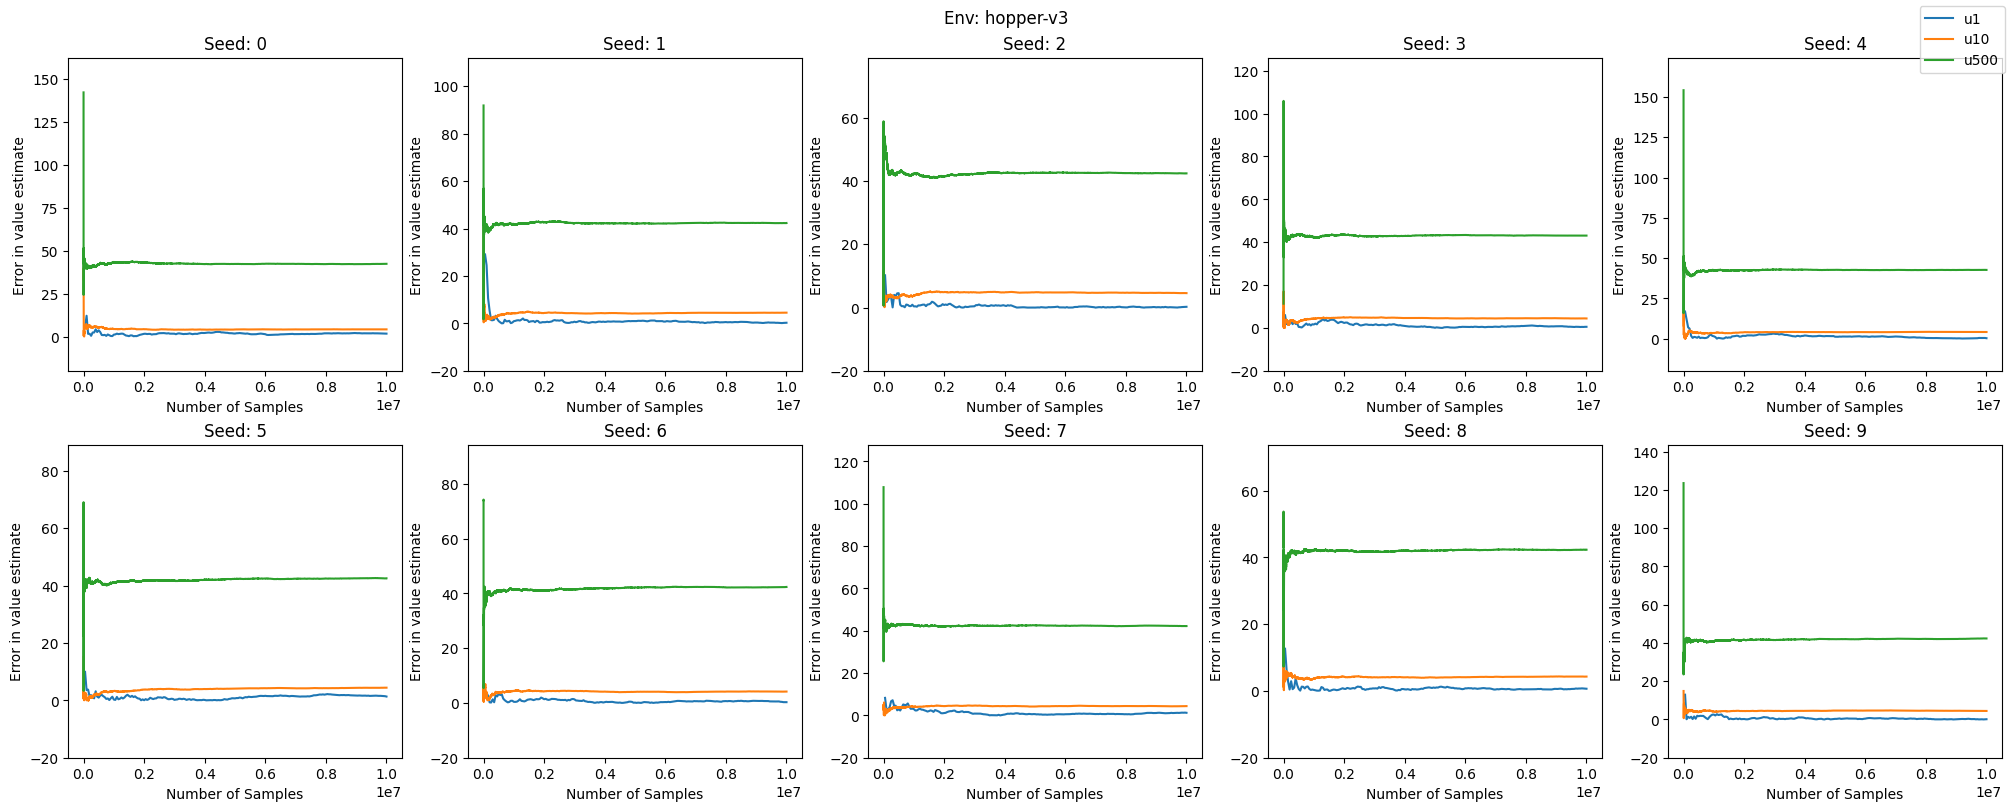

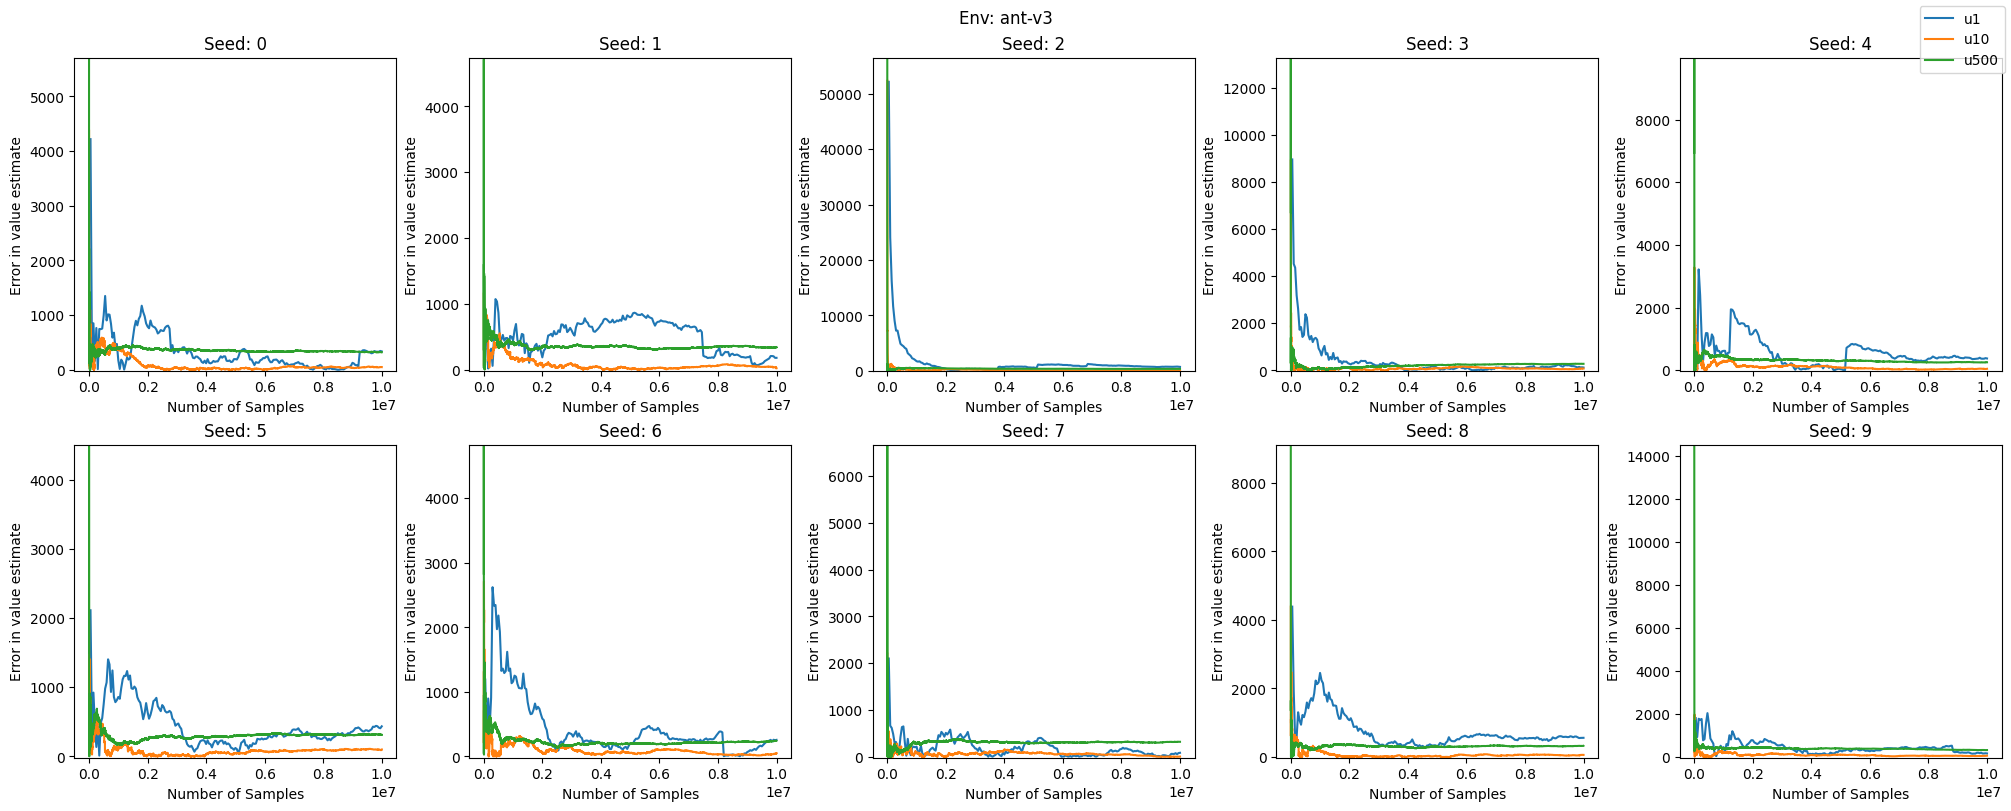

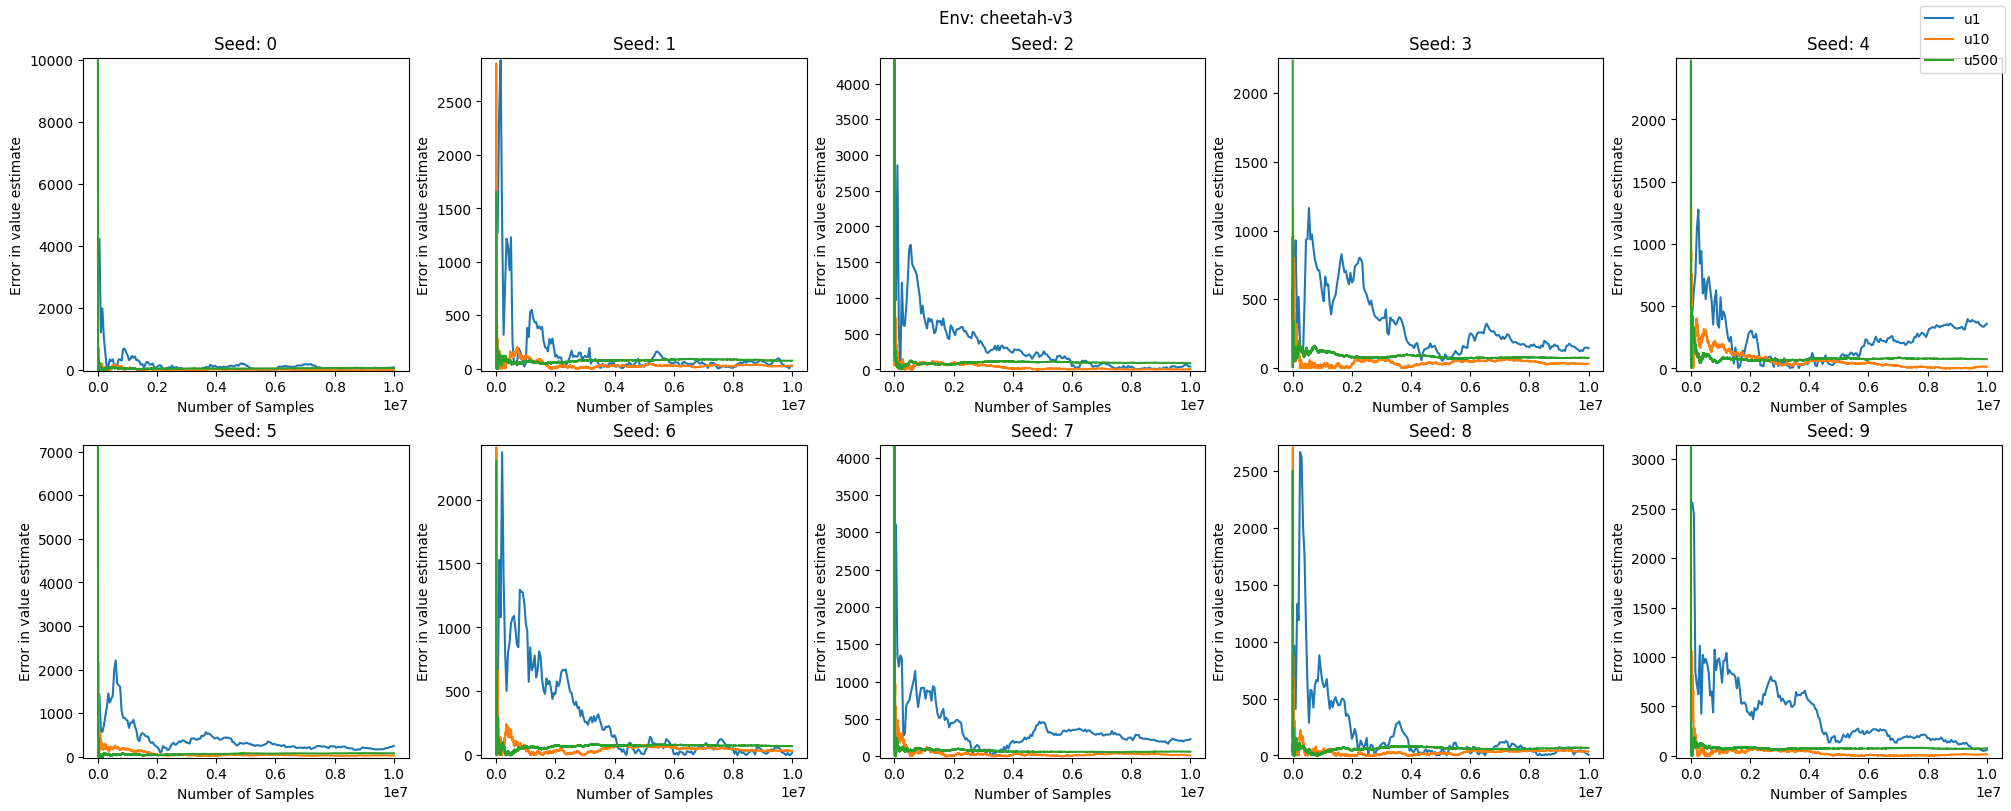

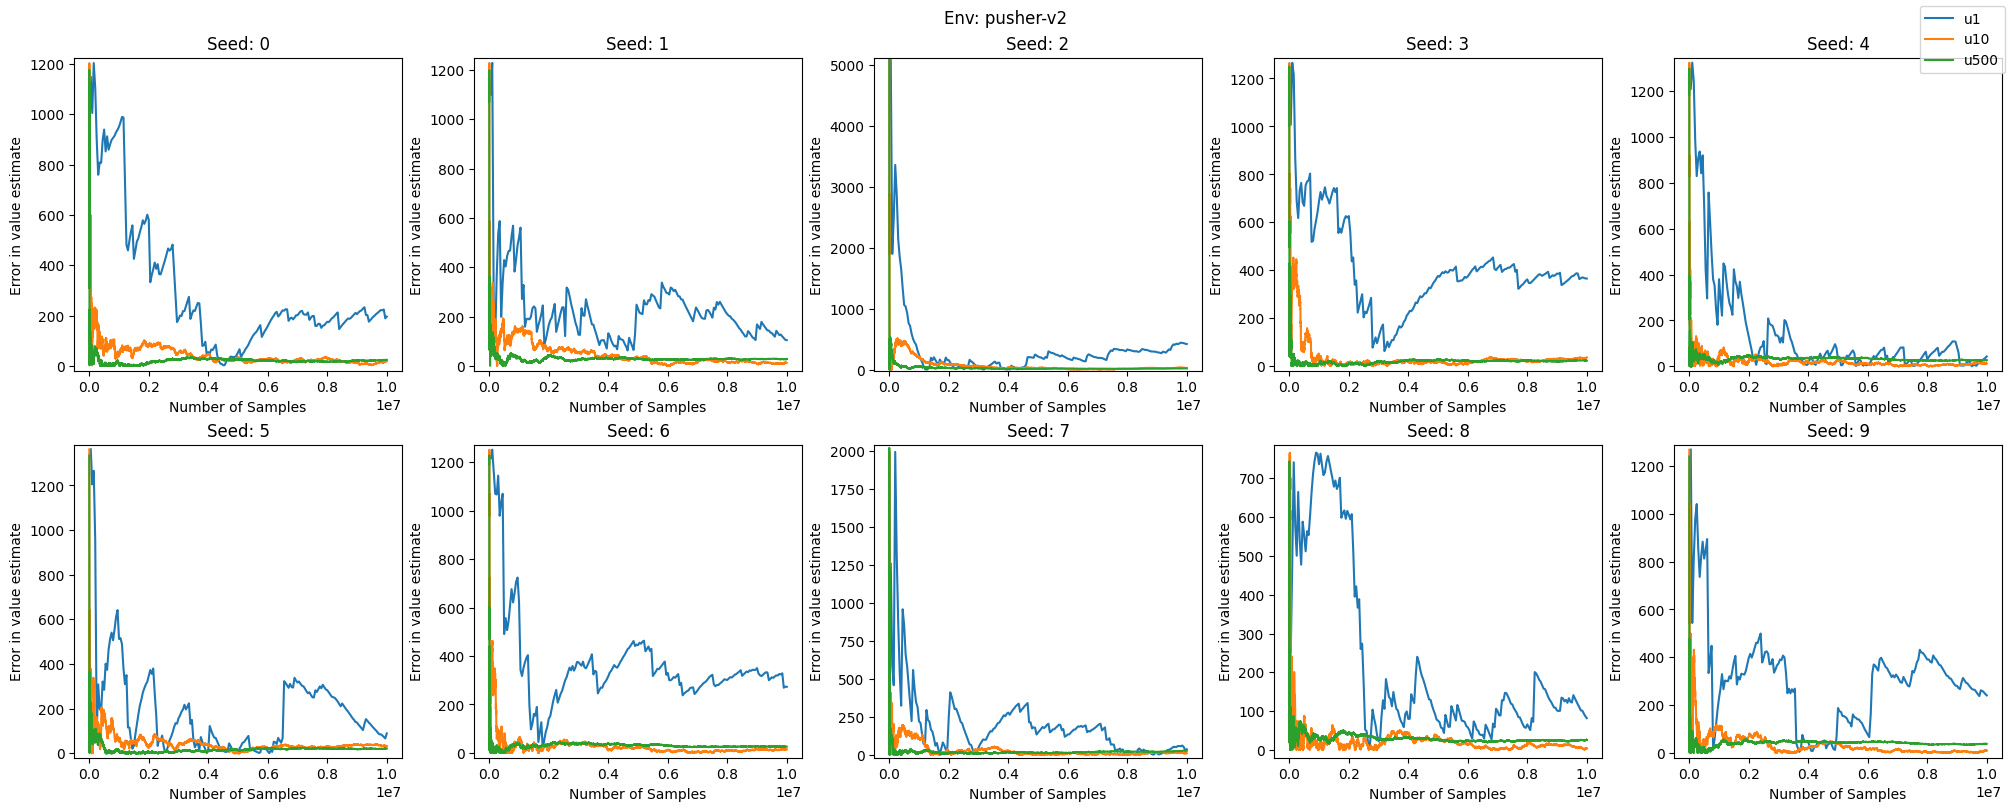

In [33]:
for env_name in est_results:
    true_value = est_results[env_name]["true_value"]

    ncols = 5
    fig, axes = plt.subplots(nrows=num_seeds // ncols, ncols=ncols, figsize=(20, 8), layout="constrained")

    for seed in range(num_seeds):
        number_of_pivots_by_episode = est_results[env_name]["runs"][seed]["number_of_pivots_by_episode"]
        estimated_values_by_episode = est_results[env_name]["runs"][seed]["estimated_values_by_episode"]
        
        ax = axes[seed // ncols, seed % ncols]
        max_diff = 0
        for s in samplers_tried.keys():
            if "q" in s:
                continue
            ax.plot(
                number_of_pivots_by_episode[s],
                np.abs(estimated_values_by_episode[s]-true_value),
                label=s if seed == 0 else "")
            curr_max_diff = np.max(np.abs(estimated_values_by_episode[s]-true_value))
            if curr_max_diff > max_diff:
                max_diff = curr_max_diff

        ax.set_title("Seed: {}".format(seed))
        ax.set_ylabel("Error in value estimate")
        ax.set_ylim(-20, max_diff + 20)
        ax.set_xlabel("Number of Samples")
    fig.legend()
    fig.suptitle("Env: {}".format(env_name))
    plt.show()

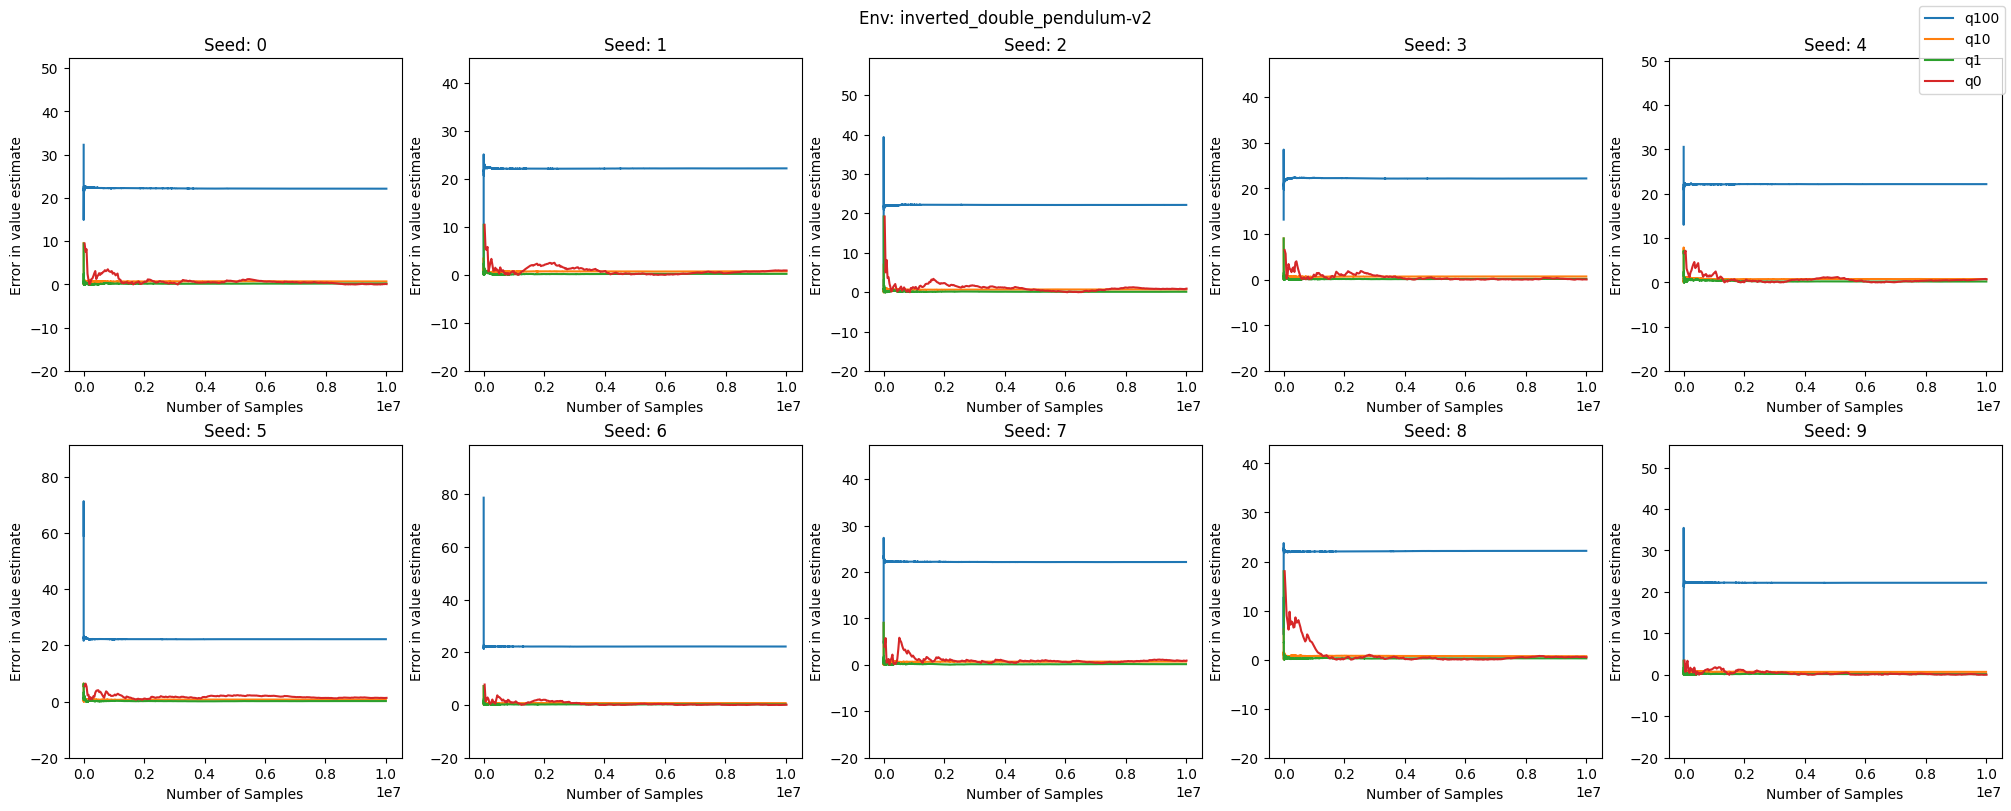

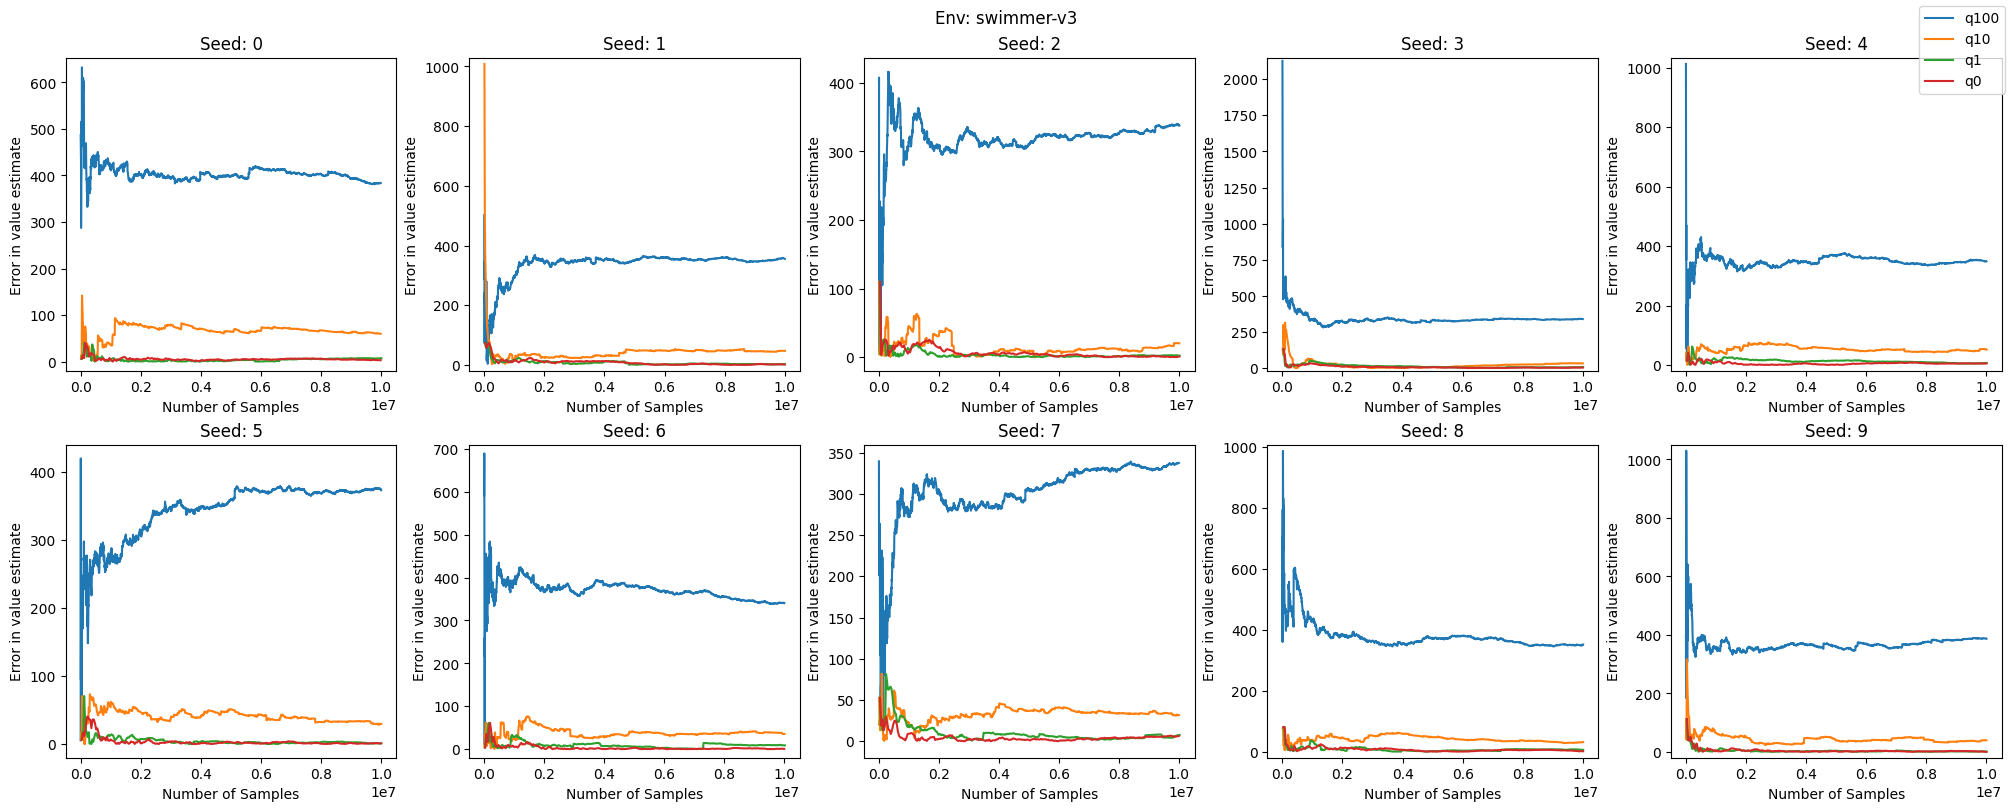

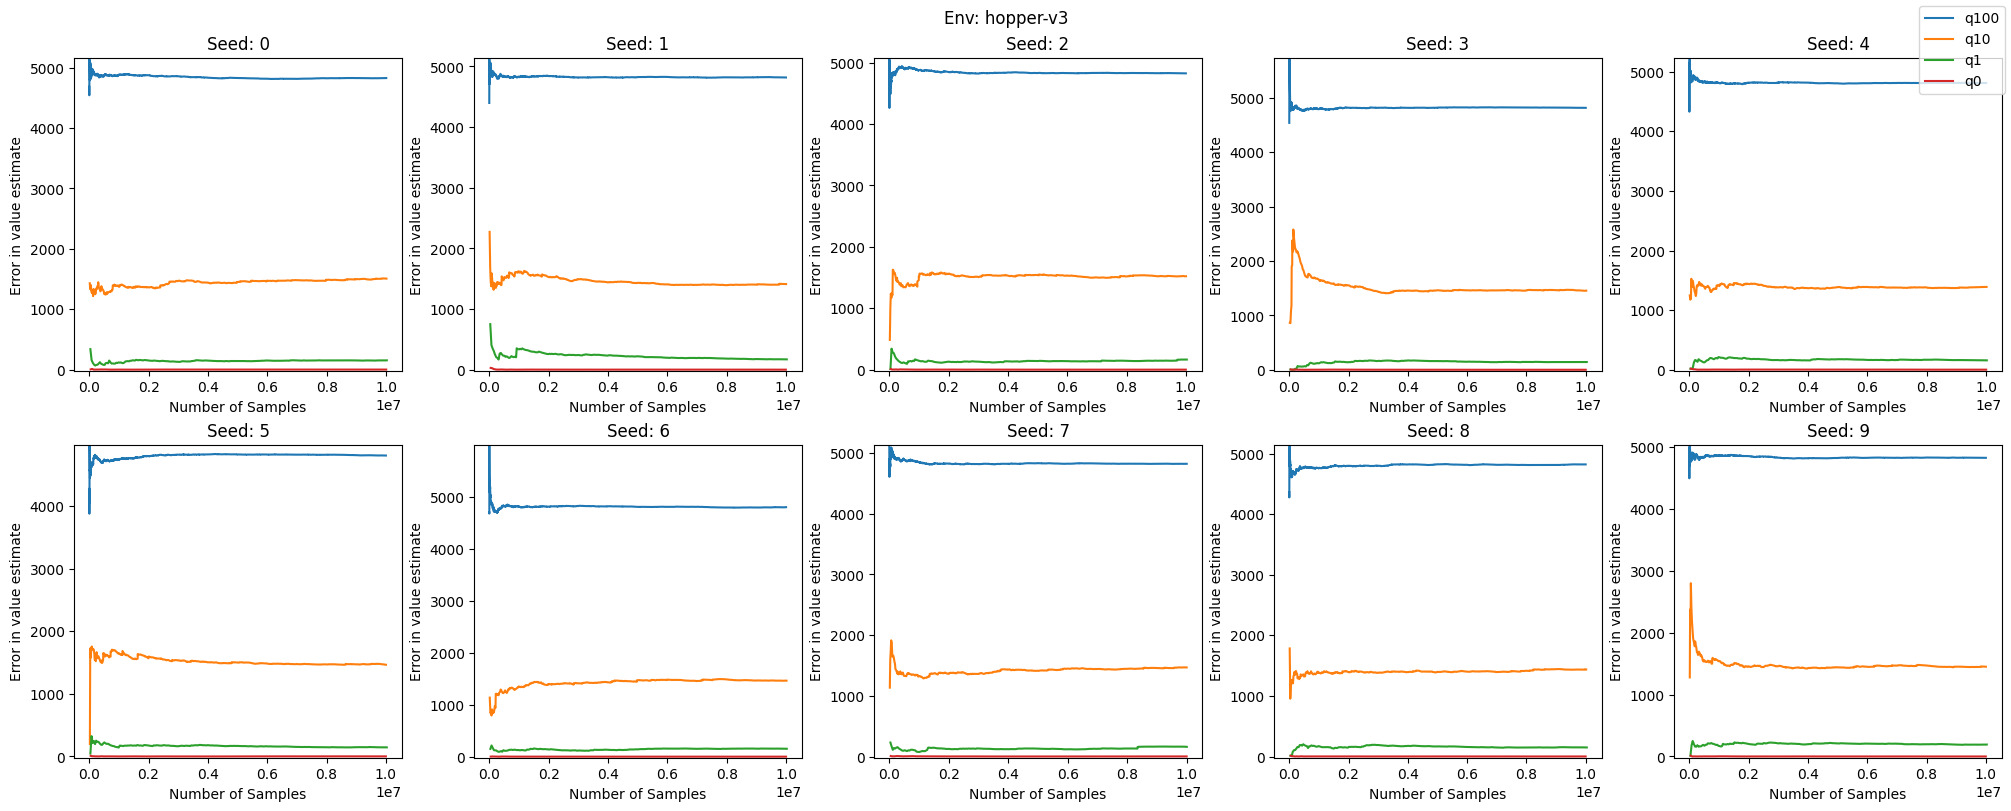

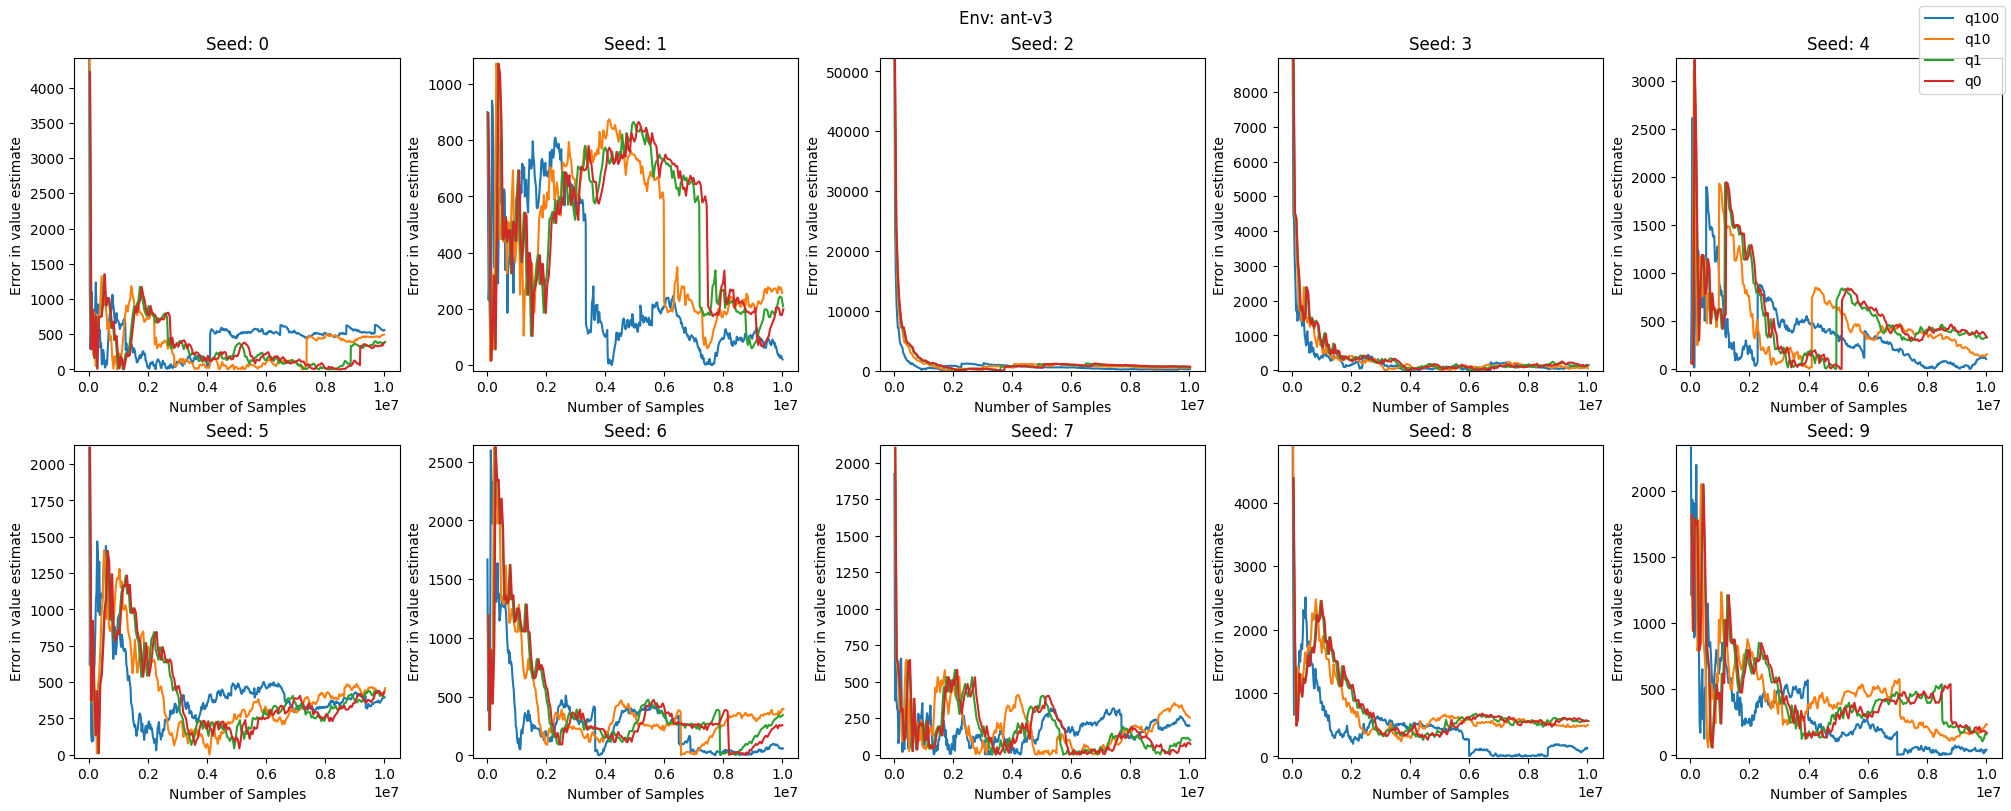

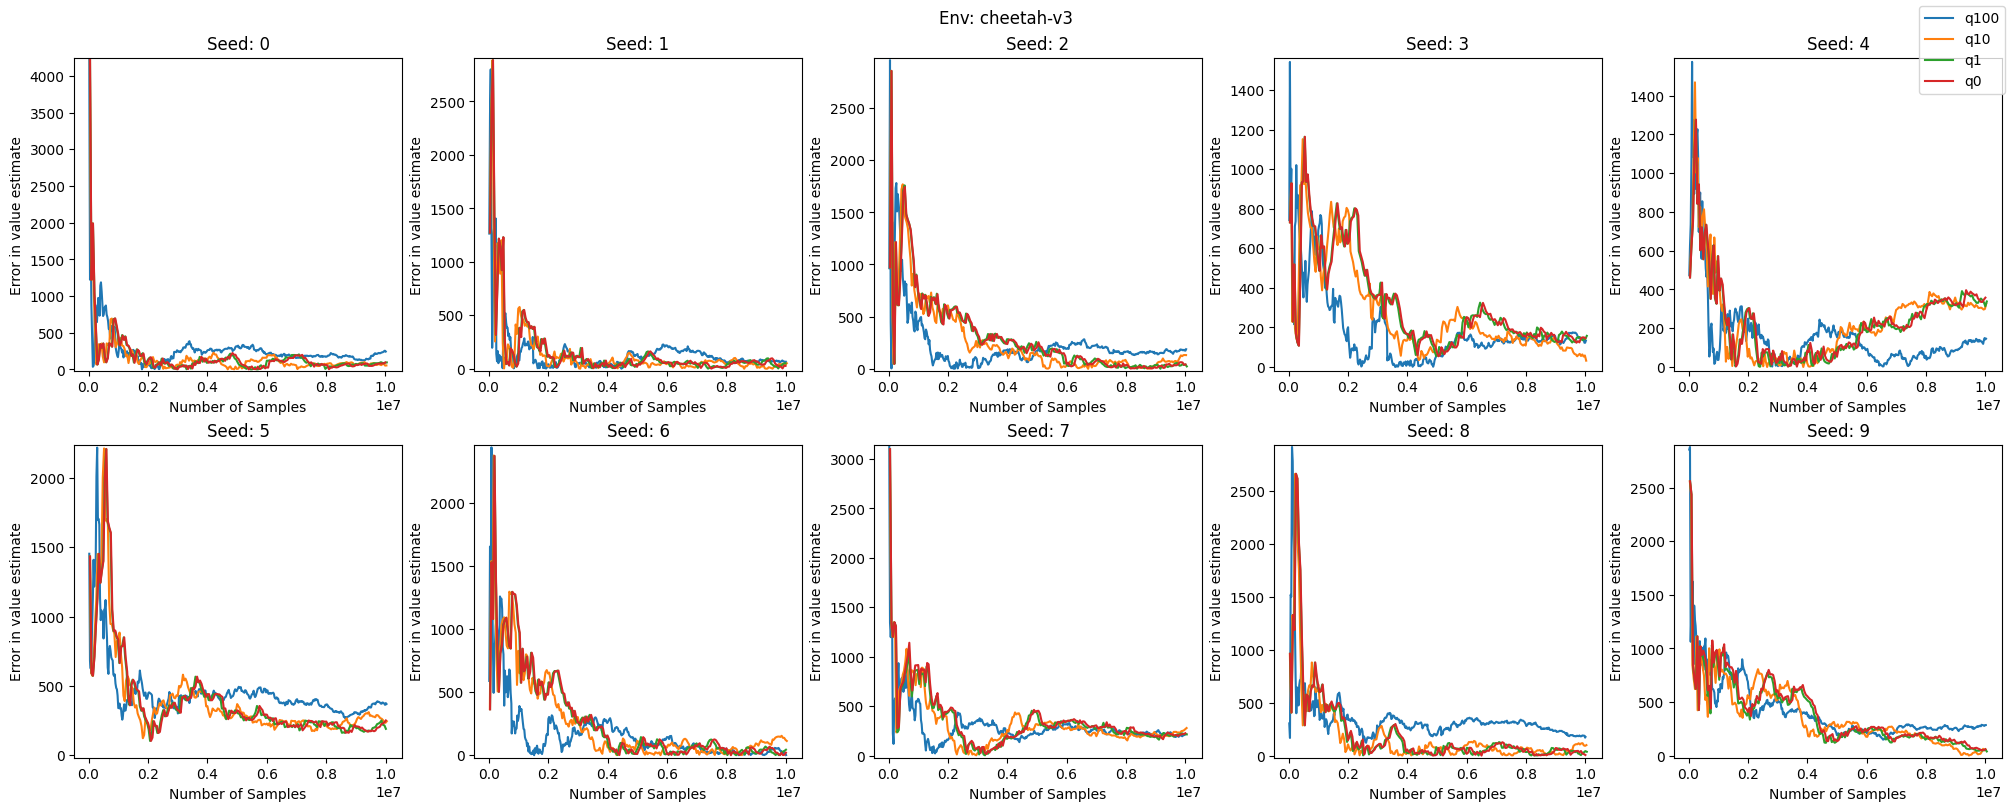

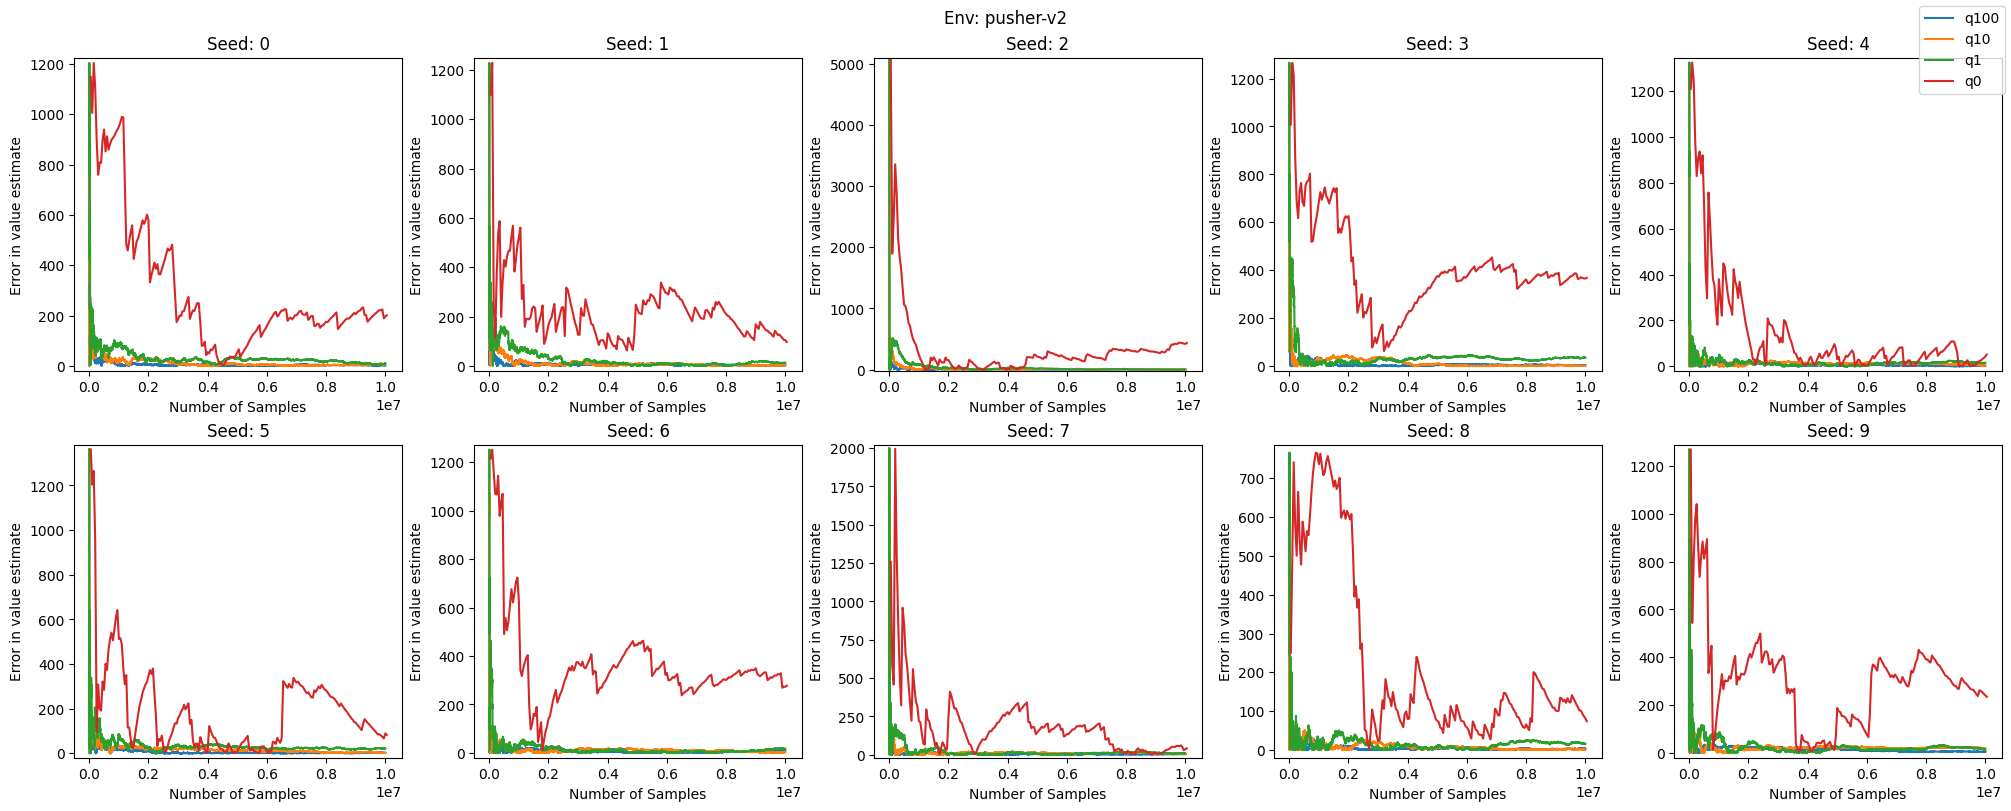

In [34]:
for env_name in est_results:
    true_value = est_results[env_name]["true_value"]

    ncols = 5
    fig, axes = plt.subplots(nrows=num_seeds // ncols, ncols=ncols, figsize=(20, 8), layout="constrained")

    for seed in range(num_seeds):
        number_of_pivots_by_episode = est_results[env_name]["runs"][seed]["number_of_pivots_by_episode"]
        estimated_values_by_episode = est_results[env_name]["runs"][seed]["estimated_values_by_episode"]
        
        ax = axes[seed // ncols, seed % ncols]
        max_diff = 0
        for s in samplers_tried.keys():
            if "q" not in s:
                continue
            ax.plot(
                number_of_pivots_by_episode[s],
                np.abs(estimated_values_by_episode[s]-true_value),
                label=s if seed == 0 else "")
            curr_max_diff = np.max(np.abs(estimated_values_by_episode[s]-true_value))
            if curr_max_diff > max_diff:
                max_diff = curr_max_diff

        ax.set_title("Seed: {}".format(seed))
        ax.set_ylabel("Error in value estimate")
        ax.set_ylim(-20, max_diff + 20)
        ax.set_xlabel("Number of Samples")
    fig.legend()
    fig.suptitle("Env: {}".format(env_name))
    plt.show()

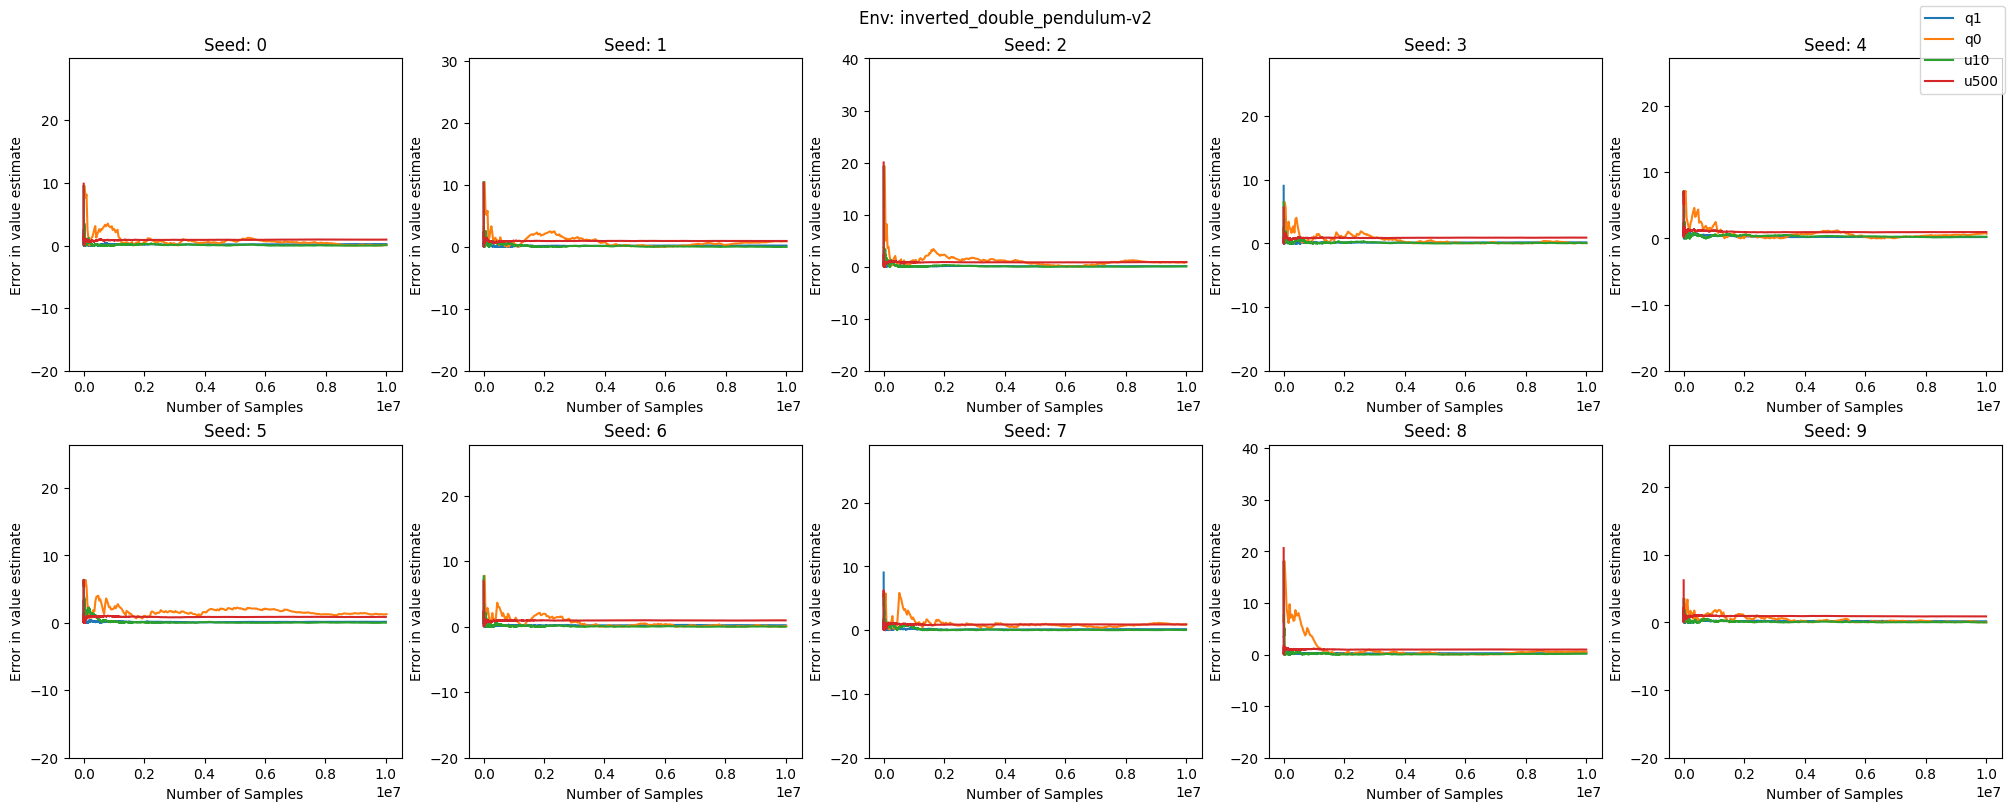

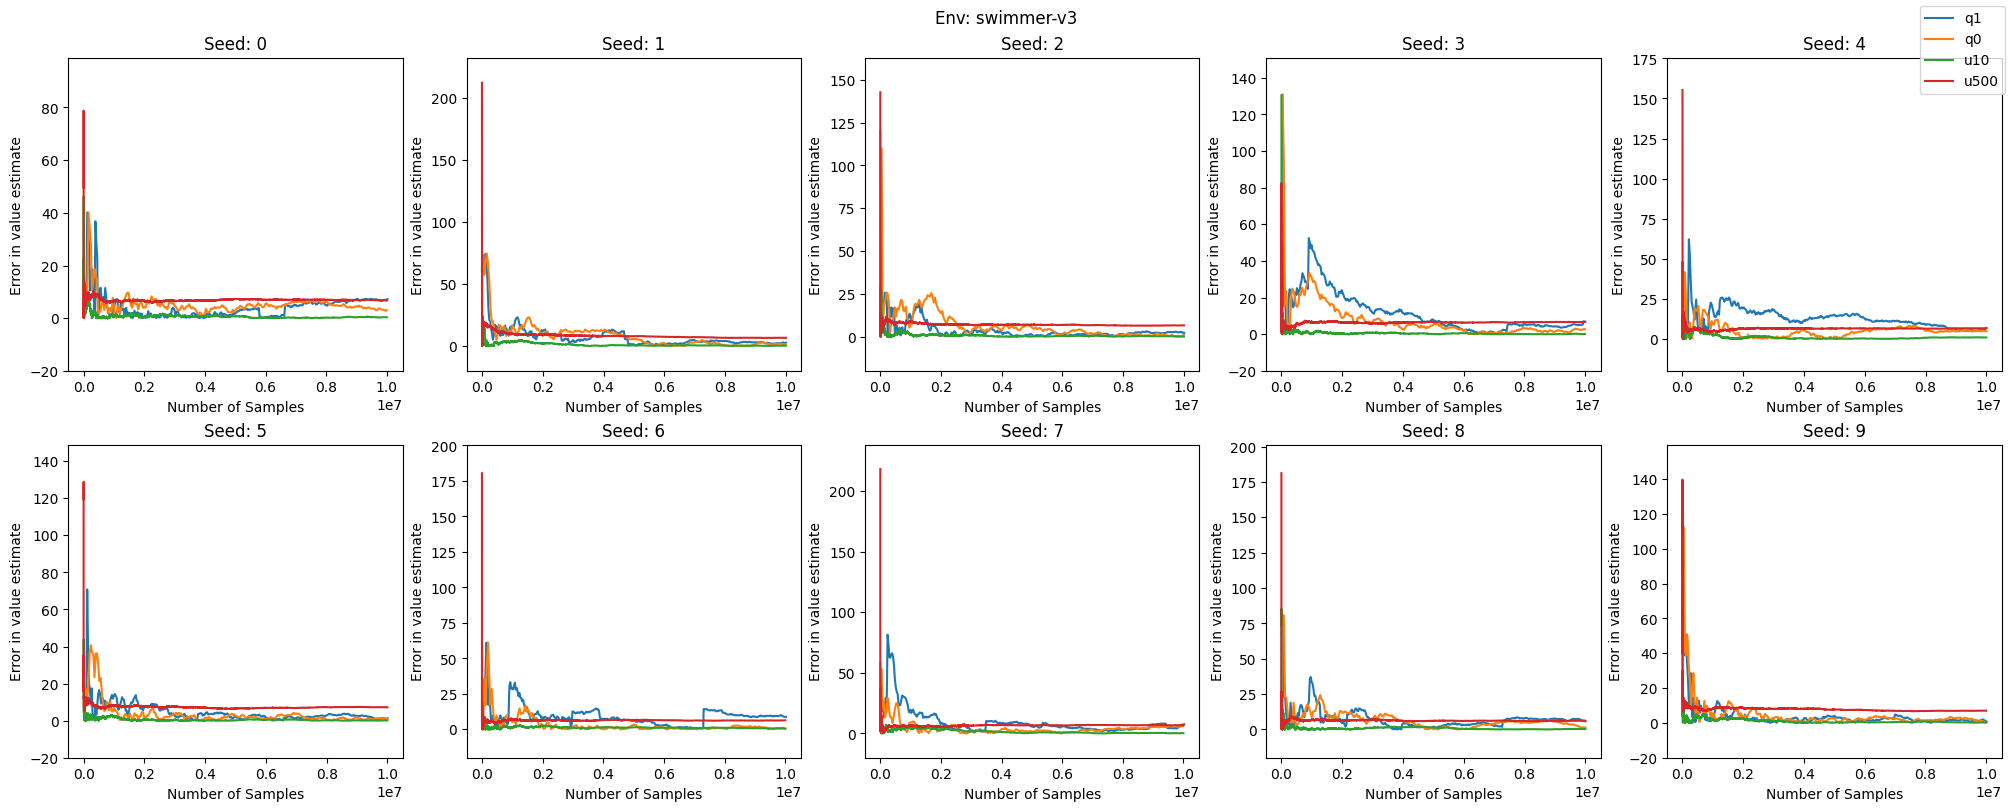

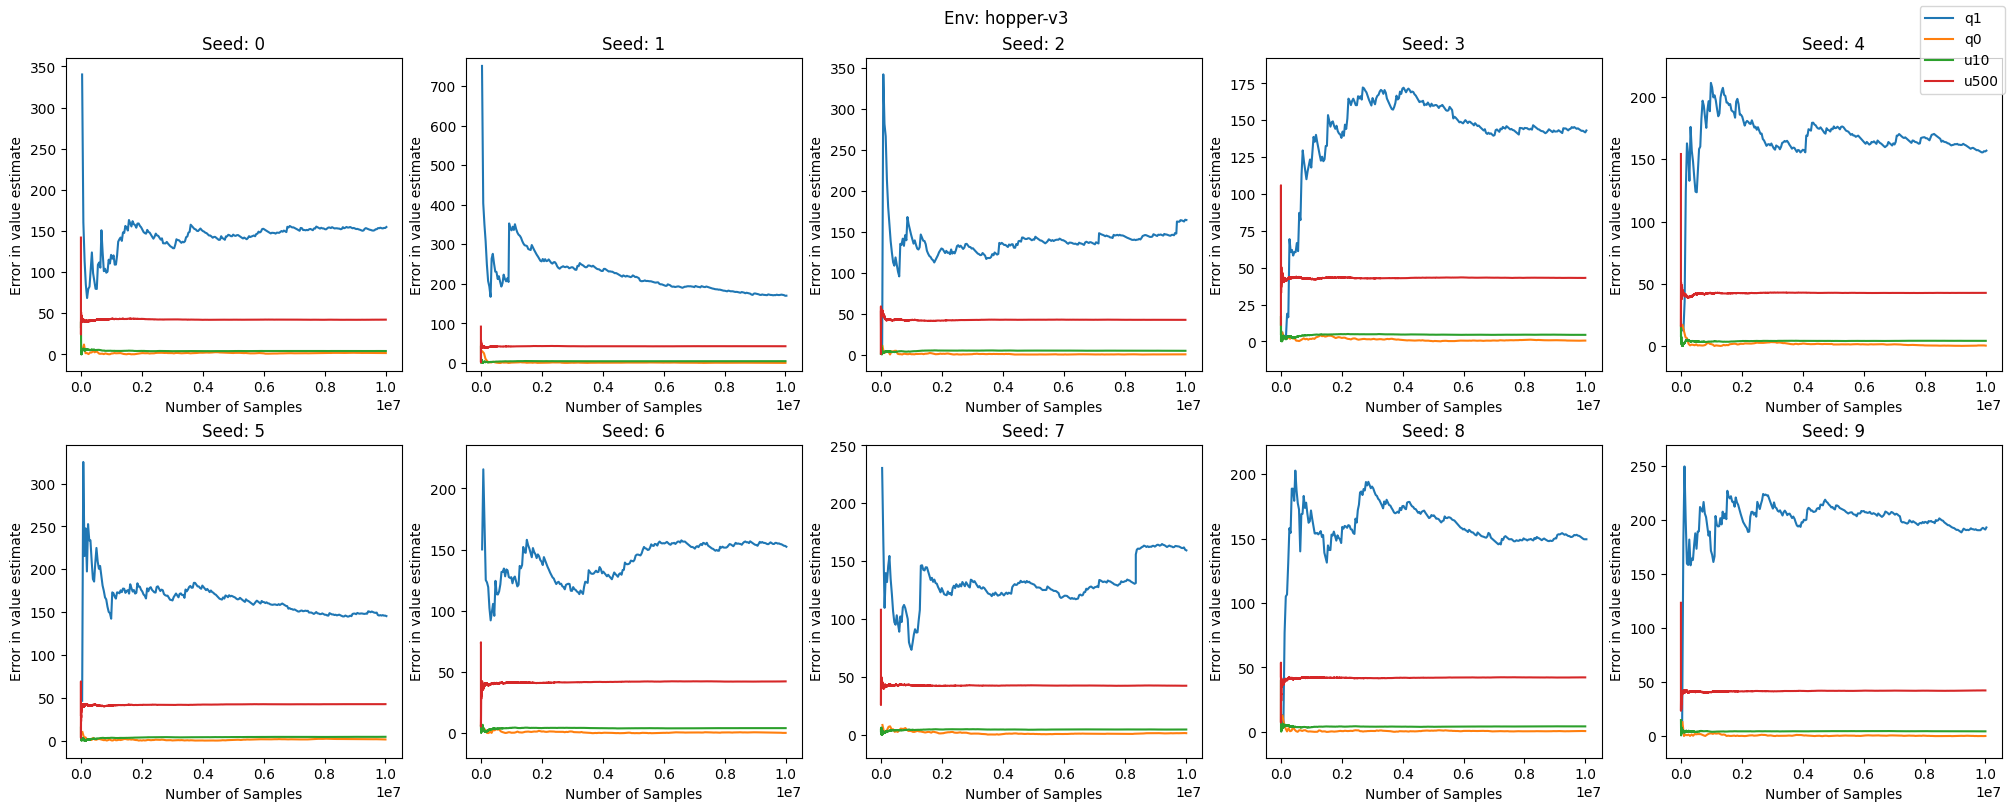

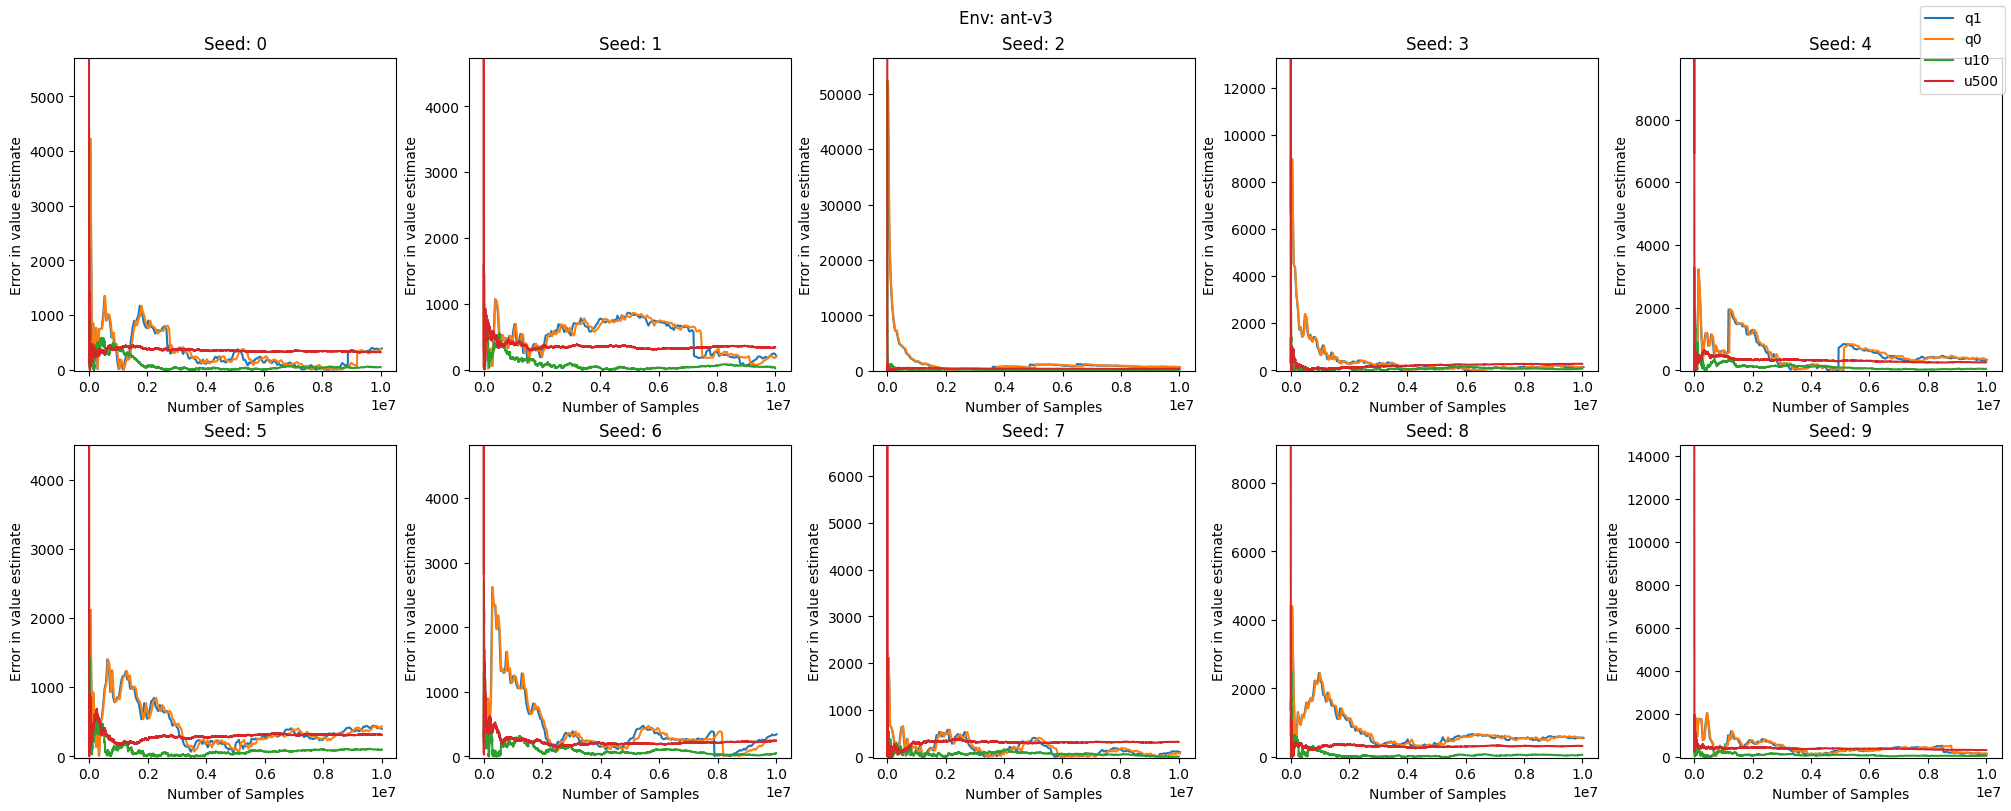

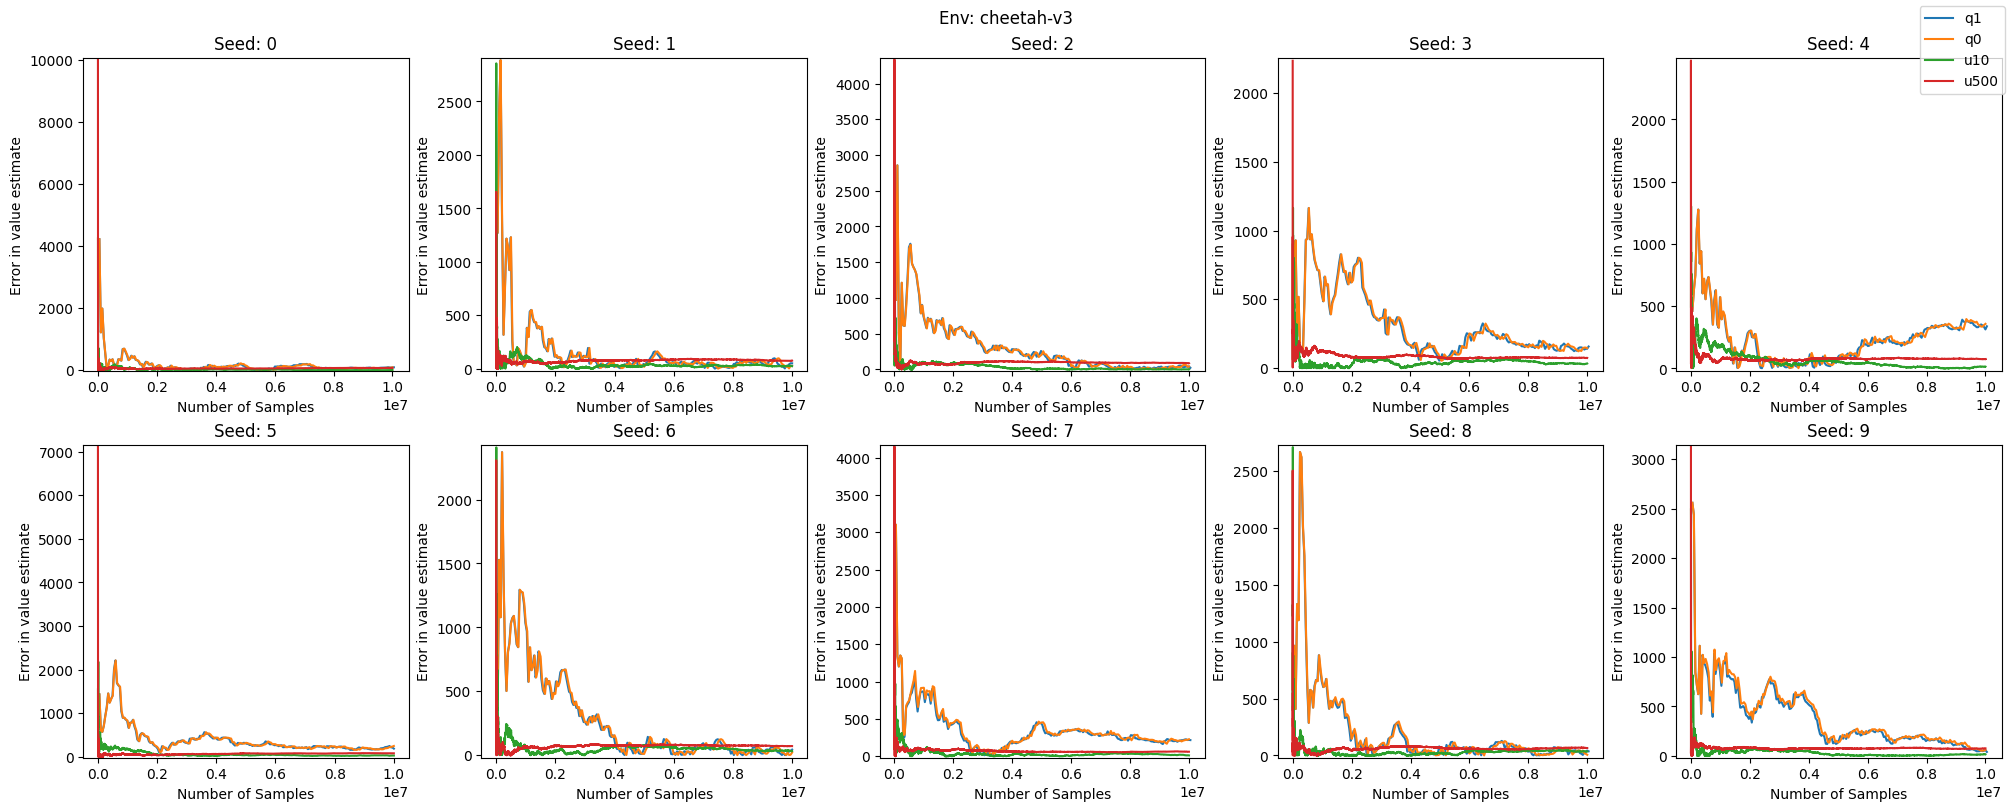

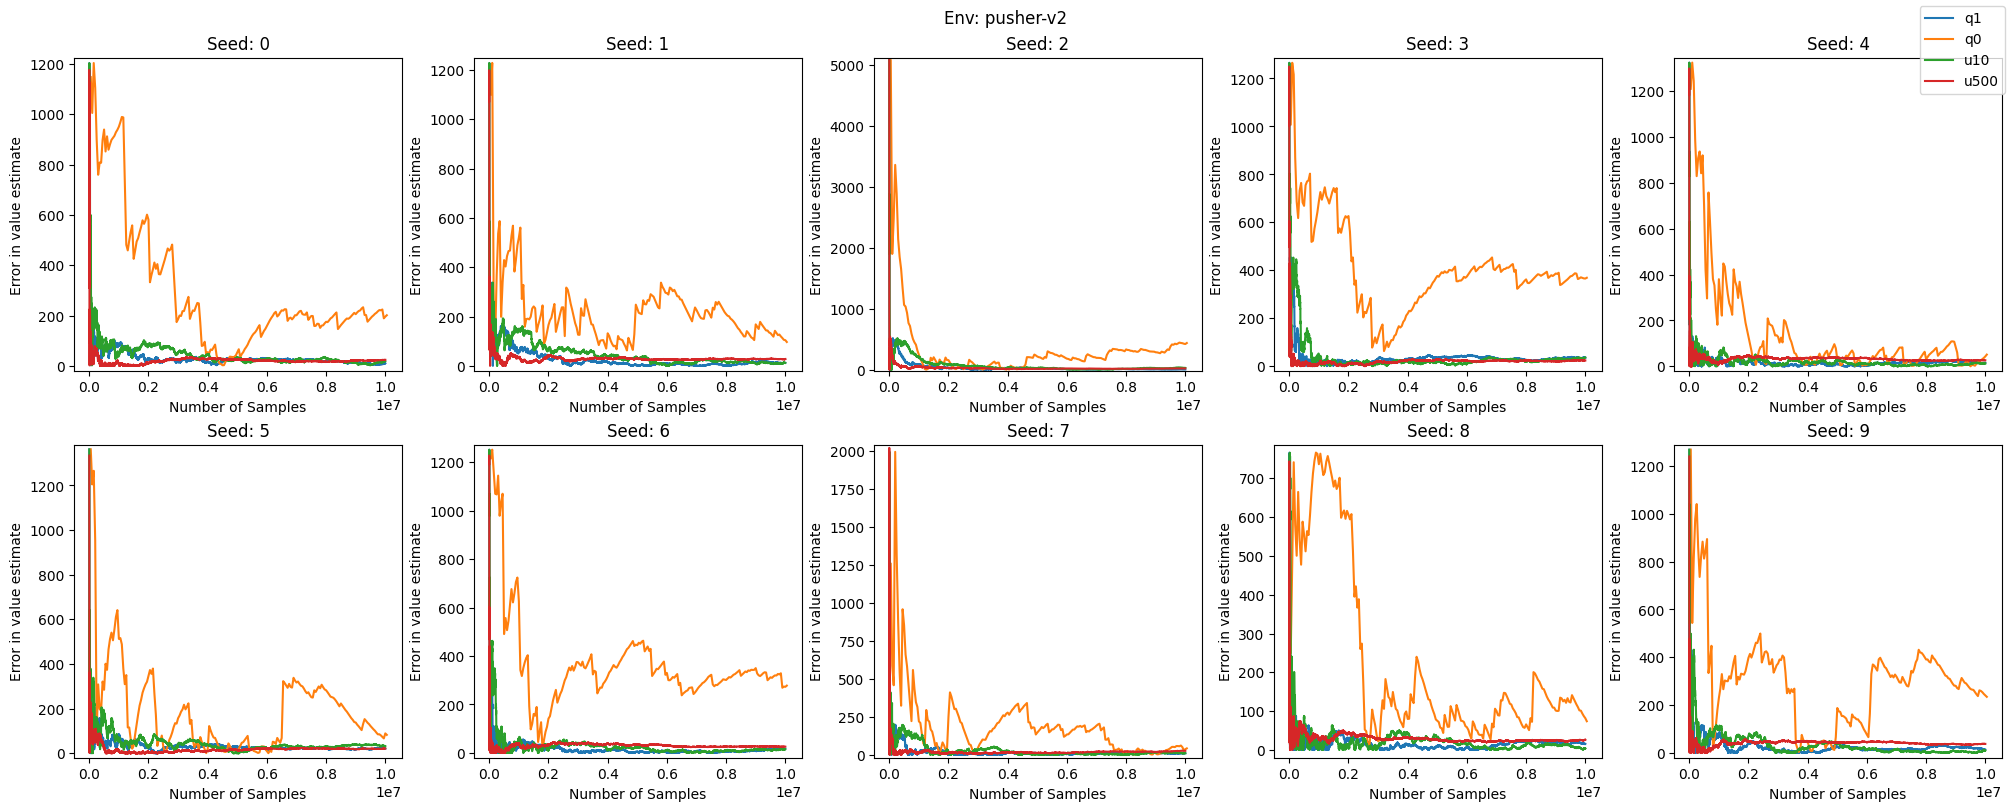

In [36]:
s_to_plot = ["q1", "q0", "u10", "u500"]
for env_name in est_results:
    true_value = est_results[env_name]["true_value"]

    ncols = 5
    fig, axes = plt.subplots(nrows=num_seeds // ncols, ncols=ncols, figsize=(20, 8), layout="constrained")

    for seed in range(num_seeds):
        number_of_pivots_by_episode = est_results[env_name]["runs"][seed]["number_of_pivots_by_episode"]
        estimated_values_by_episode = est_results[env_name]["runs"][seed]["estimated_values_by_episode"]
        
        ax = axes[seed // ncols, seed % ncols]
        max_diff = 0
        for s in s_to_plot:
            ax.plot(
                number_of_pivots_by_episode[s],
                np.abs(estimated_values_by_episode[s]-true_value),
                label=s if seed == 0 else "")
            curr_max_diff = np.max(np.abs(estimated_values_by_episode[s]-true_value))
            if curr_max_diff > max_diff:
                max_diff = curr_max_diff

        ax.set_title("Seed: {}".format(seed))
        ax.set_ylabel("Error in value estimate")
        ax.set_ylim(-20, max_diff + 20)
        ax.set_xlabel("Number of Samples")
    fig.legend()
    fig.suptitle("Env: {}".format(env_name))
    plt.show()